# 1 Beginners

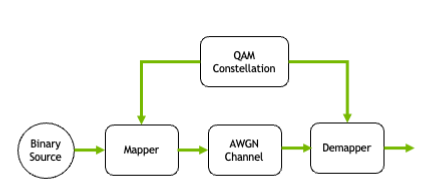

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

In [ ]:
# Constellation

NUM_BITS_PER_SYMBOL = 4 # QPSK
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

constellation.show(figsize=(7,7));

In [ ]:
# Mapper and Demapper

mapper = sn.mapping.Mapper(constellation=constellation)

# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

In [ ]:
binary_source = sn.utils.BinarySource()

awgn_channel = sn.channel.AWGN()

no = sn.utils.ebnodb2no(ebno_db=10.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

BATCH_SIZE = 64 # How many examples are processed by Sionna in parallel

bits = binary_source([BATCH_SIZE,
                      1024]) # Blocklength
print("Shape of bits: ", bits.shape)
print(bits)

x = mapper(bits)
print("Shape of x: ", x.shape)
print("x=",x)

y = awgn_channel([x, no])
print("Shape of y: ", y.shape)
print("y=",y)

llr = demapper([y, no])
print("Shape of llr: ", llr.shape)
print("llr=",llr)

In [ ]:
num_samples = 8 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")

In [ ]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

In [ ]:
# Task: Change the SNR or Eb/N0 to 30dB to visualize the impact on the received samples
no_1 = sn.utils.ebnodb2no(ebno_db=30.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

no_2 = sn.utils.ebnodb2no(ebno_db=10.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

no_3 = sn.utils.ebnodb2no(ebno_db=1.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

BATCH_SIZE = 64 # How many examples are processed by Sionna in parallel
bits = binary_source([BATCH_SIZE,
                      1024]) # Blocklength
x = mapper(bits)
y_1 = awgn_channel([x, no_1])
llr_1 = demapper([y_1, no_1])
y_2 = awgn_channel([x, no_2])
llr_2 = demapper([y_2, no_2])
y_3 = awgn_channel([x, no_3])
llr_3 = demapper([y_3, no_3])

plt.figure(figsize=(7,7))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.subplot(3,1,1)
plt.scatter(tf.math.real(y_1), tf.math.imag(y_1))
plt.subplot(3,1,2)
plt.scatter(tf.math.real(y_2), tf.math.imag(y_2))
plt.subplot(3,1,3)
plt.scatter(tf.math.real(y_3), tf.math.imag(y_3))
plt.tight_layout()

## 1.1 Forward Error Correction (FEC)

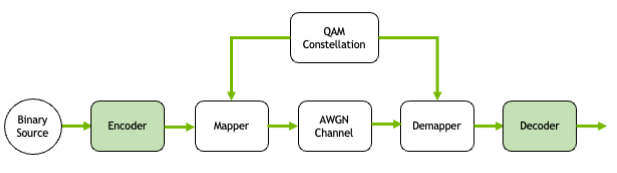

### Linear Codes

In [ ]:
# Linear Encoder

inputs = np.matrix('0 0 1') # Information Bits
print('inputs:',inputs)
gm = np.matrix('1 0 0 1 1 0; 0 1 0 0 1 1; 0 0 1 1 0 1') # Generator Matrix
print('gm:',gm)
c = tf.linalg.matmul(inputs, gm) # Codewords = Information Bits * Generator Matrix
print('c:',c)

# faster implementation of tf.math.mod(c, 2)
c_uint8 = tf.cast(c, tf.uint8)
print('c_uint8:',c_uint8)
c_bin = tf.bitwise.bitwise_and(c_uint8, tf.constant(1, tf.uint8))
print('c_bin:',c_bin)
c = tf.cast(c_bin, tf.float32)
print('c:',c)

### LDPC

In [ ]:
k = 12
n = 20

encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

BATCH_SIZE = 1 # one codeword in parallel
u = binary_source([BATCH_SIZE, k])
print("Input bits are: \n", u.numpy())

c = encoder(u)
print("Encoded bits are: \n", c.numpy())

### BATCH_SIZE=2, num_basestations=3, num_users=4, k=15

In [ ]:
BATCH_SIZE = 2 # samples per scenario
num_basestations = 3 
num_users = 4 # users per basestation
n = 30 # codeword length per transmitted codeword
coderate = 0.5 # coderate

k = int(coderate * n) # number of info bits per codeword

# instantiate a new encoder for codewords of length n
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# the decoder must be linked to the encoder (to know the exact code parameters used for encoding)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder,
                                    hard_out=True, # binary output or provide soft-estimates
                                    return_infobits=True, # or also return (decoded) parity bits
                                    num_iter=20, # number of decoding iterations
                                    cn_type="boxplus-phi") # also try "minsum" decoding

# draw random bits to encode
u = binary_source([BATCH_SIZE, num_basestations, num_users, k])
print("Shape of u: ", u.shape)
print('u = ', u)

# We can immediately encode u for all users, basetation and samples 
# This all happens with a single line of code
c = encoder(u)
print("Shape of c: ", c.shape)

print("Total number of processed bits: ", np.prod(c.shape))

### BATCH_SIZE=10, num_basestations=4, num_users=5, k=500

In [ ]:
BATCH_SIZE = 10 # samples per scenario
num_basestations = 4 
num_users = 5 # users per basestation
n = 1000 # codeword length per transmitted codeword
coderate = 0.5 # coderate

k = int(coderate * n) # number of info bits per codeword

# instantiate a new encoder for codewords of length n
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# the decoder must be linked to the encoder (to know the exact code parameters used for encoding)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder,
                                    hard_out=True, # binary output or provide soft-estimates
                                    return_infobits=True, # or also return (decoded) parity bits
                                    num_iter=20, # number of decoding iterations
                                    cn_type="boxplus-phi") # also try "minsum" decoding

# draw random bits to encode
u = binary_source([BATCH_SIZE, num_basestations, num_users, k])
print("Shape of u: ", u.shape)

# We can immediately encode u for all users, basetation and samples 
# This all happens with a single line of code
c = encoder(u)
print("Shape of c: ", c.shape)

print("Total number of processed bits: ", np.prod(c.shape))

In [ ]:
k = 64
n = 128

encoder = sn.fec.polar.Polar5GEncoder(k, n)
decoder = sn.fec.polar.Polar5GDecoder(encoder,
                                      dec_type="SCL") # you can also use "SCL" 

## Plot SER (Uncoded System)

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = 1024
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

bers = []
sers = []
snrs = []

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):
    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

    bits = binary_source([BATCH_SIZE,
                        BLOCK_LENGTH]) # Blocklength
    #print("Shape of bits: ", bits.shape)
    #print(bits)

    x = mapper(bits)
    #print("Shape of x: ", x.shape)
    #print("x=",x)

    y = awgn_channel([x, no])
    #print("Shape of y: ", y.shape)
    #print("y=",y)

    llr = demapper([y, no])
    #print("Shape of llr: ", llr.shape)
    #print("llr=",llr)

    bits_hat = hard_decisions(llr)

    x_hat = mapper(bits_hat)

    ber = compute_ber(bits, bits_hat)
    #print("Shape of ber: ", ber.shape)
    #print('ber=', ber)
    ser = compute_ser(x, x_hat)
    #print("Shape of ser: ", ser.shape)
    #print('ser=', ser)

    bers += [ber]
    sers += [ser]
    snrs += [EBN0_DB]

#print('snrs=', snrs)
#print('bers=', bers)
#print('Shape of bers', bers.shape)
#print('sers=', sers)
#print('Shape of sers', snrs.shape)

title = "Uncoded System with AWGN Channel"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Log"
legend1 = 'BER'
legend2 = 'SER'
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers, 'm-v', label='BER')
plt.semilogy(snrs, sers, 'g-o', label='SER')
plt.legend(loc='upper right', fontsize=10)
plt.show()

### About sionna.utils.hard_decisions

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = 1024
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations
EBN0_DB = 1

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

bits = binary_source([BATCH_SIZE,
                    BLOCK_LENGTH]) # Blocklength
#print("Shape of bits: ", bits.shape)
#print(bits)

x = mapper(bits)
#print("Shape of x: ", x.shape)
#print("x=",x)

y = awgn_channel([x, no])
#print("Shape of y: ", y.shape)
#print("y=",y)

llr = demapper([y, no])
#print("Shape of llr: ", llr.shape)
print("llr=",llr)

bits_hat = hard_decisions(llr)
print("bits_hat=",bits_hat)

x_hat = mapper(bits_hat)

### Plot ln(x) to Explain LLR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x range
x = np.linspace(-2, 2, 101)

# Calculate the y values
y = np.log(x)

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('x')
plt.ylabel('ln(x)')
plt.title('Logarithmic function')
plt.text(x[75], y[75], y[75], color = 'r')  # Mark the point (0,1)
# Remove frame of chart
ax = plt.gca()  # Get current axis
ax.spines['right'].set_color('none')  # Set right frame's color as none
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
 
# Set the central of axis as（0，0）
ax.spines['bottom'].set_position(('data', 0))  # The bottom of the specified data setting (that is, the specified x-axis) is bound to the point 0 of the y-axis
ax.spines['left'].set_position(('data', 0))

# Show the plot
plt.show()

## Plot SRE (Coded System)

snrs= [-3.0]
snrs= [-3.0, -2.0]
snrs= [-3.0, -2.0, -1.0]
snrs= [-3.0, -2.0, -1.0, 0.0]
snrs= [-3.0, -2.0, -1.0, 0.0, 1.0]
snrs= [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0]
snrs= [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]
snrs= [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
snrs= [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


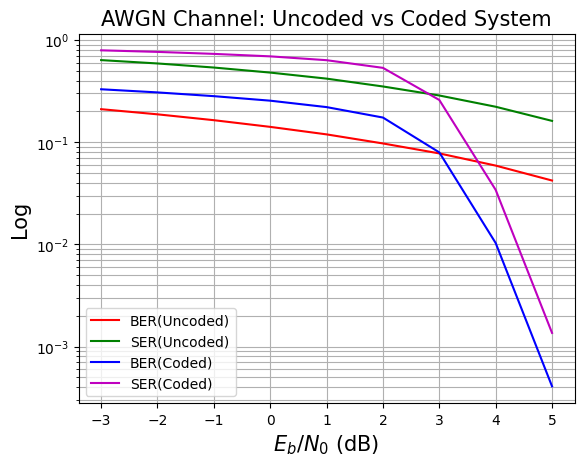

In [47]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

NUM_BITS_PER_SYMBOL = 4 # QPSK
#BLOCK_LENGTH = 1024
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# LDPC Encoder
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

bers = []
sers = []
bers_1 = []
sers_1 = []
snrs = []

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,9):
    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
    
    no_1 = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 0.5 as we do coded transmission here


    bits = binary_source([BATCH_SIZE,k]) # Blocklength:k
    #print("Shape of bits: ", bits.shape)
    #print(bits)

    symbols = mapper(bits)

    codewords = encoder(bits)

    x = mapper(bits)
    #print("Shape of x: ", x.shape)
    #print("x=",x)

    x_1 = mapper(codewords)
    #print("Shape of x: ", x.shape)
    #print("x=",x)

    y = awgn_channel([x, no])
    #print("Shape of y: ", y.shape)
    #print("y=",y)

    y_1 = awgn_channel([x_1, no_1])
    #print("Shape of y: ", y.shape)
    #print("y=",y)

    llr = demapper([y, no])
    #print("Shape of llr: ", llr.shape)
    #print("llr=",llr)

    llr_1 = demapper([y_1, no_1])
    #print("Shape of llr: ", llr.shape)
    #print("llr=",llr)

    bits_hat = hard_decisions(llr)

    bits_hat_1 = decoder(llr_1)

    x_hat = mapper(bits_hat)

    symbols_hat = mapper(bits_hat_1)

    ber = compute_ber(bits, bits_hat)
    #print("Shape of ber: ", ber.shape)
    #print('ber=', ber)

    ber_1 = compute_ber(bits, bits_hat_1)
    #print("Shape of ber: ", ber.shape)
    #print('ber=', ber)

    ser = compute_ser(x, x_hat)

    ser_1 = compute_ser(symbols, symbols_hat)
    #print("Shape of ser: ", ser.shape)
    #print('ser=', ser)

    snrs += [EBN0_DB]
    bers += [ber]
    bers_1 += [ber_1]
    sers += [ser]
    sers_1 += [ser_1]

    print('snrs=', snrs)
    # print('bers=', bers)
    # print('bers_1=', bers_1)
    # print('sers=', sers)
    # print('sers_1=', sers_1)

title = "AWGN Channel: Uncoded vs Coded System"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Log"
# legend1 = 'BER(Uncoded)'
# legend2 = 'SER(Uncoded)'
# legend3 = 'BER(Coded)'
# legend4 = 'SER(Coded)'
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers, 'r', label='BER(Uncoded)')
plt.semilogy(snrs, sers, 'g', label='SER(Uncoded)')
plt.semilogy(snrs, bers_1, 'b', label='BER(Coded)')
plt.semilogy(snrs, sers_1, 'm', label='SER(Coded)')
plt.legend(loc='lower left', fontsize=10)
plt.show()

# 2 Experts

## 2.2 Bit_Interleaved_Coded_Modulation

In [ ]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
# Load the required Sionna components
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder, LDPCBPDecoder
from sionna.fec.interleaving import RandomInterleaver, Deinterleaver
from sionna.fec.scrambling import Scrambler, Descrambler
from sionna.fec.utils import GaussianPriorSource, load_parity_check_examples, get_exit_analytic, plot_exit_chart, plot_trajectory
from sionna.utils import BinarySource, ebnodb2no, hard_decisions
from sionna.utils.plotting import PlotBER
from sionna.channel import AWGN

# show QPSK constellation
constellation = Constellation("qam", num_bits_per_symbol=2)
constellation.show();

# generate 16QAM with Gray labeling
constellation = Constellation("qam", num_bits_per_symbol=4)
constellation.show();